In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import os
import json
import gc

import cv2
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import webcolors
from PIL import Image, ImageDraw

from minimal.layout import InputLayout
from minimal.imaging import draw_plan
from minimal.gen import run_model

%matplotlib inline

In [3]:
from minimal import sample_graphs

from pregen.premade import premade_graphs
from pregen import signature as sg

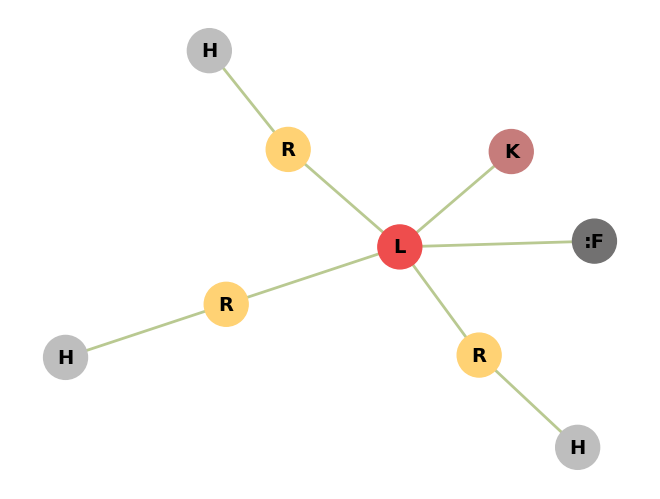

In [14]:
g.draw()

In [16]:
g = InputLayout(node_types=[0, 1, 2, 2, 2, 3, 3, 3, 14],
                edges=[(8, 0), (0, 4),(0, 2), (0, 1), (2, 7), (4, 6), (0, 3), (3, 5)],
                node_labels=[1, 8, 2, 3, 4, 5, 6, 7, 0])

sg.find_closest_graph(g) is premade_graphs[45]
# premade_graphs[45]

True

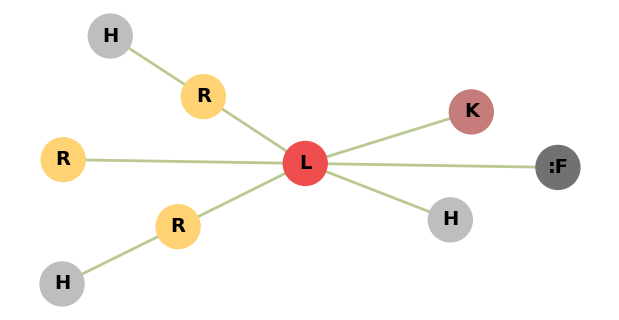

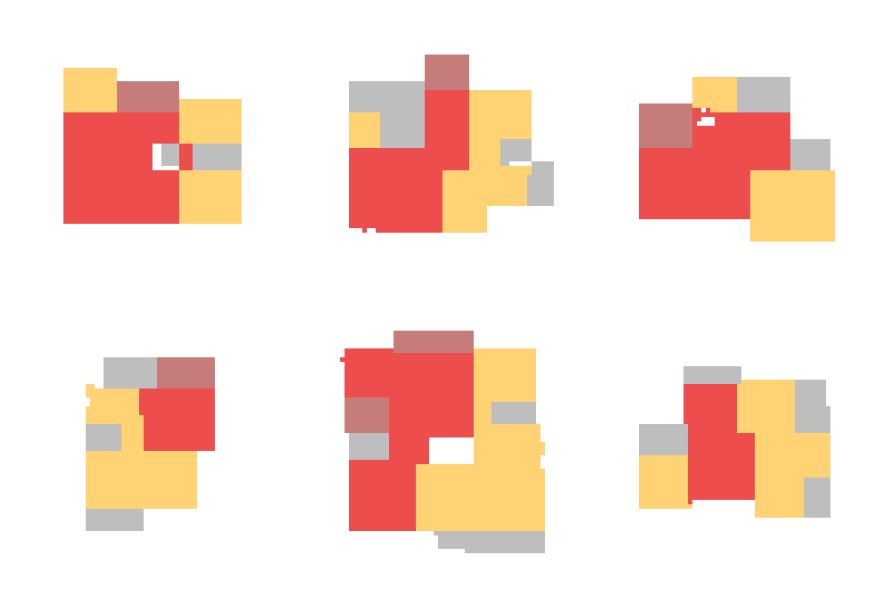

In [89]:
gi = 47
g = premade_graphs[gi]

NUM_MAPS = 6
results = []
for i in range(NUM_MAPS):
    masks = run_model(g, num_iters=10)
    results.append(masks)

plt.figure(figsize=(6,3))
g.draw()

_, axes = plt.subplots(2,3, figsize=(9, 6), gridspec_kw={'wspace': 0, 'hspace': 0})
axes = axes.flatten().tolist()
for i, ax in enumerate(axes):
    ax.axis('off')
    ax.imshow(draw_plan(results[i], g.node_types))
plt.tight_layout()

In [90]:
save(2,4)
del results
gc.collect()

14696

In [19]:
def save(*nums):
    for n in nums:
        if n > 0 and n <= NUM_MAPS:
            save_tensor(results[n - 1])

def save_tensor(tensor):
    folder = "plibrary/" + sg.graph_folder_name(g)

    # Create the folder if it does not exist
    os.makedirs(folder, exist_ok=True)

    # Ensure meta file exists
    meta_path = os.path.join(folder, "meta.json")
    if not os.path.exists(meta_path):
        with open(meta_path, "w") as f:
            json.dump({"count": 0}, f)

    meta_path = os.path.join(folder, "meta.json")
    with open(meta_path, "r") as f:
        meta = json.load(f)
    count = meta.get("count", 0)
    new_count = count + 1

    # Save the tensor with the new count as filename
    tensor_path = os.path.join(folder, f"{new_count}.pth")
    torch.save(tensor, tensor_path)

    # Update the meta.json with new count
    meta["count"] = new_count
    with open(meta_path, "w") as f:
        json.dump(meta, f)
